In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from torch.utils.data import DataLoader, TensorDataset

C:\Users\bagus\AppData\Local\Temp\ipykernel_31032\1293868963.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=data, x='quality', palette='viridis')


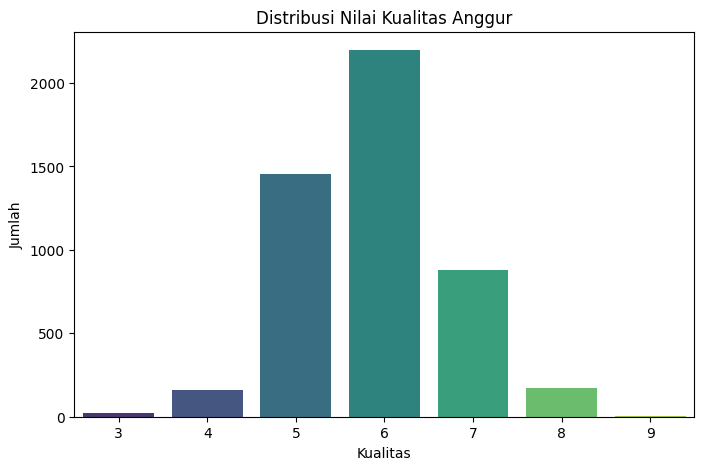

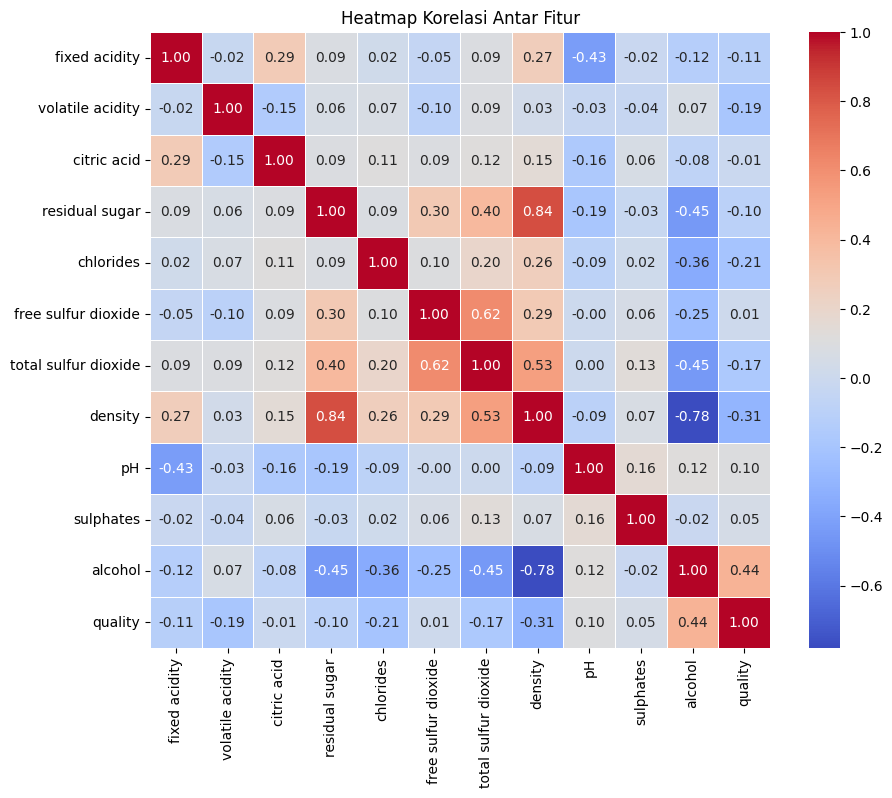

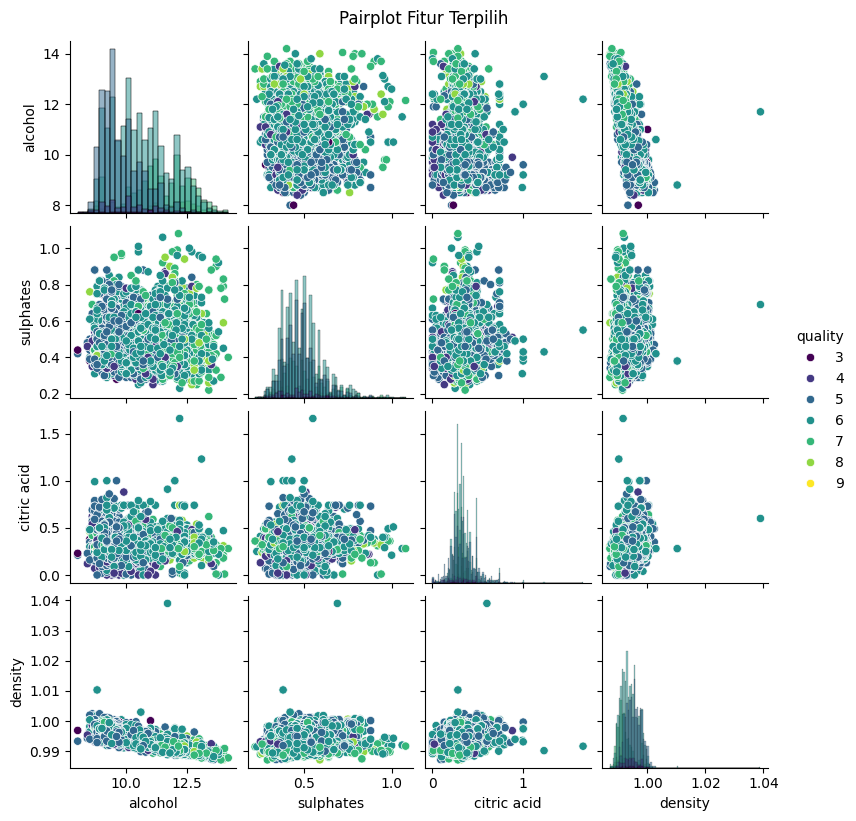

In [2]:
# Load and preprocess the dataset
file_path = 'winequality-white.csv'
data = pd.read_csv(file_path, delimiter=';')

# Exploratory Data Analysis (EDA)
plt.figure(figsize=(8, 5))
sns.countplot(data=data, x='quality', palette='viridis')
plt.title('Distribusi Nilai Kualitas Anggur')
plt.xlabel('Kualitas')
plt.ylabel('Jumlah')
plt.show()

plt.figure(figsize=(10, 8))
correlation_matrix = data.corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)
plt.title('Heatmap Korelasi Antar Fitur')
plt.show()

selected_features = ['alcohol', 'sulphates', 'citric acid', 'density', 'quality']
sns.pairplot(data[selected_features], hue='quality', palette='viridis', diag_kind='hist', height=2)
plt.suptitle('Pairplot Fitur Terpilih', y=1.02)
plt.show()


In [3]:
# Feature selection and scaling
X = data.drop('quality', axis=1)
y = data['quality']
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

# Convert to PyTorch tensors
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train.values, dtype=torch.long)
y_test_tensor = torch.tensor(y_test.values, dtype=torch.long)

train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)


In [5]:
# Define the RNN model
class RNNModel(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, pooling_type='max'):
        super(RNNModel, self).__init__()
        self.rnn = nn.RNN(input_size, hidden_size, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)
        self.pooling_type = pooling_type

    def forward(self, x):
        out, _ = self.rnn(x)
        if self.pooling_type == 'max':
            out = torch.max(out, dim=1)[0]
        elif self.pooling_type == 'avg':
            out = torch.mean(out, dim=1)
        out = self.fc(out)
        return out

# Experiment configurations
hidden_sizes = [16, 32, 64]
pooling_types = ['max', 'avg']
epochs_list = [5, 50, 100, 250]
optimizers = {'SGD': optim.SGD, 'RMSProp': optim.RMSprop, 'Adam': optim.Adam}

best_accuracy = 0
best_config = {}

In [6]:
for hidden_size in hidden_sizes:
    for pooling_type in pooling_types:
        for epochs in epochs_list:
            for opt_name, opt_class in optimizers.items():
                print(f"Training with hidden_size={hidden_size}, pooling_type={pooling_type}, epochs={epochs}, optimizer={opt_name}")
                # Model initialization
                model = RNNModel(input_size=X_train_tensor.shape[1], hidden_size=hidden_size, output_size=len(y.unique()), pooling_type=pooling_type)
                criterion = nn.CrossEntropyLoss()
                optimizer = opt_class(model.parameters(), lr=0.01)

                # Training loop
                for epoch in range(epochs):
                    model.train()
                    for X_batch, y_batch in train_loader:
                        optimizer.zero_grad()
                        outputs = model(X_batch.unsqueeze(1))

                        # Adjust target range to match output classes
                        y_batch_adjusted = y_batch - y_batch.min()
                        loss = criterion(outputs, y_batch_adjusted)

                        loss.backward()
                        optimizer.step()
                    print(f"Epoch [{epoch+1}/{epochs}], Loss: {loss.item():.4f}")

                # Evaluate the model
                model.eval()
                correct = 0
                total = 0
                with torch.no_grad():
                    for X_batch, y_batch in test_loader:
                        outputs = model(X_batch.unsqueeze(1))
                        _, predicted = torch.max(outputs, 1)

                        # Adjust target range to match output classes
                        y_batch_adjusted = y_batch - y_batch.min()
                        total += y_batch_adjusted.size(0)
                        correct += (predicted == y_batch_adjusted).sum().item()

                accuracy = correct / total
                print(f"Accuracy: {accuracy:.4f}")

                # Save best configuration
                if accuracy > best_accuracy:
                    best_accuracy = accuracy
                    best_config = {
                        'hidden_size': hidden_size,
                        'pooling_type': pooling_type,
                        'epochs': epochs,
                        'optimizer': opt_name
                    }

Training with hidden_size=16, pooling_type=max, epochs=5, optimizer=SGD
Epoch [1/5], Loss: 1.9749
Epoch [2/5], Loss: 1.5103
Epoch [3/5], Loss: 1.4872
Epoch [4/5], Loss: 1.3768
Epoch [5/5], Loss: 1.5281
Accuracy: 0.3653
Training with hidden_size=16, pooling_type=max, epochs=5, optimizer=RMSProp
Epoch [1/5], Loss: 1.0548
Epoch [2/5], Loss: 1.1191
Epoch [3/5], Loss: 1.4042
Epoch [4/5], Loss: 1.6009
Epoch [5/5], Loss: 1.1519
Accuracy: 0.3694
Training with hidden_size=16, pooling_type=max, epochs=5, optimizer=Adam
Epoch [1/5], Loss: 1.4085
Epoch [2/5], Loss: 1.3744
Epoch [3/5], Loss: 1.1278
Epoch [4/5], Loss: 1.1036
Epoch [5/5], Loss: 1.3091
Accuracy: 0.3571
Training with hidden_size=16, pooling_type=max, epochs=50, optimizer=SGD
Epoch [1/50], Loss: 1.7885
Epoch [2/50], Loss: 1.4429
Epoch [3/50], Loss: 1.8175
Epoch [4/50], Loss: 1.3412
Epoch [5/50], Loss: 1.4535
Epoch [6/50], Loss: 1.5004
Epoch [7/50], Loss: 1.2760
Epoch [8/50], Loss: 1.6264
Epoch [9/50], Loss: 1.7172
Epoch [10/50], Loss: 1

In [7]:
# Display the best configuration and accuracy
print("Best Configuration:", best_config)
print("Best Accuracy:", best_accuracy)


Best Configuration: {'hidden_size': 64, 'pooling_type': 'max', 'epochs': 50, 'optimizer': 'RMSProp'}
Best Accuracy: 0.38571428571428573
